# Eploratory Data Analysis (The Manufacturing Process) 

This notebok will focus on exploratory data analysis of the manufacturing dataset and will show a deeper understanding of the data, identify any patterns, reviewing any issues (missing or incorrectly formatted data) & will apply statistical techinques to gain insight on the data's distribution. It will also apply visiualtion techinques to indentify patterns or trends in the data 

## Necessary Imports

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from db_utils import RDSDatabaseConnector
from plotts import Plotter
from scipy import stats
from transformations import DataFrameTransform
from sklearn.preprocessing import PowerTransformer

## Loading in the dataset

The manufacturing csv from the AWS RDS was previoulsy extracted and saved locally. This is now loaded as a pandas  dataframe to allow use of EDA techniques. We also print the 5 rows of the data set to show that it is correctly loaded into the data frame

In [41]:
df = pd.read_csv('failure_data.csv')

print("\nFirst 5 Rows of the Dataset:")
print(df.head())



First 5 Rows of the Dataset:
    UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0  3416     L50595    L                301.4                    310.4   
1  7130     L54309    L                300.6                    310.0   
2  2320     M17179    M                299.2                    308.8   
3  9601     M24460    M                298.9                    310.0   
4   614     L47793    L                298.1                    309.9   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1579         36.9            133.0                0    0   
1                    1635         31.0            107.0                0    0   
2                    1700         33.5            185.0                0    0   
3                    1561         45.3             58.0                0    0   
4                    1634         30.0             53.0                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    

## Ensuring Columns are the correct Datatype

Here is some initial analysis on the dataframe columns datatypes, it is essential to ensure that each column in the dataset has the correct data type. This allows for accurate calulations and analysis. An example of this within our dataset is columns that should be numeric (like temperature or speed) should not be stored as text.


In [42]:
# Ensuring columns have the correct data types
df['Process temperature [K]'] = pd.to_numeric(df['Process temperature [K]'], errors='coerce')  # Ensure numeric column
df['Product ID'] = df['Product ID'].astype('category')  # Ensure categorical column

# Checking the data types of all columns
df.dtypes


UDI                           int64
Product ID                 category
Type                         object
Air temperature [K]         float64
Process temperature [K]     float64
Rotational speed [rpm]        int64
Torque [Nm]                 float64
Tool wear [min]             float64
Machine failure               int64
TWF                           int64
HDF                           int64
PWF                           int64
OSF                           int64
RNF                           int64
dtype: object

## Null Values 

Missing values are common in vaious datasets and understanding where and how much data is missing is essential. Columns with a high percentage of missing data might not be useful for analysis and different strategies (like filling or removing) should be applied based on the column's importance and the missing data's nature. Identifying null values helps us decide whether to remove rows/columns or impute missing values

In [43]:
null_counts = df.isnull().sum()  # Counts the null values in each column
null_percentage = (df.isnull().sum() / len(df)) * 100  # Percentage of null values per column

print(null_counts)
print(null_percentage)

UDI                          0
Product ID                   0
Type                         0
Air temperature [K]        838
Process temperature [K]    881
Rotational speed [rpm]       0
Torque [Nm]                  0
Tool wear [min]            484
Machine failure              0
TWF                          0
HDF                          0
PWF                          0
OSF                          0
RNF                          0
dtype: int64
UDI                        0.00
Product ID                 0.00
Type                       0.00
Air temperature [K]        8.38
Process temperature [K]    8.81
Rotational speed [rpm]     0.00
Torque [Nm]                0.00
Tool wear [min]            4.84
Machine failure            0.00
TWF                        0.00
HDF                        0.00
PWF                        0.00
OSF                        0.00
RNF                        0.00
dtype: float64


## Handling missing values

Once we've identified the null values the next task is deciding how to handle them. Depending on the amount and nature of the missing data, we can either drop the rows/columns or fill in the missing values with a statistical measure (mean, median, or mode). Proper handling of missing data is critical because ignoring or improperly handling them can distort the results of this analysis

In [ ]:
# Dropping columns with too many null values (e.g., more than 50%)
df_cleaned = df.dropna(thresh=len(df) * 0.5, axis=1)

# Imputing missing values with the median for numeric columns
df_cleaned['Process temperature [K]'] = df_cleaned['Process temperature [K]'].fillna(df_cleaned['Process temperature [K]'].median())

# Verifying if there are still any null values
print(df_cleaned.isnull().sum())


UDI                          0
Product ID                   0
Type                         0
Air temperature [K]        838
Process temperature [K]      0
Rotational speed [rpm]       0
Torque [Nm]                  0
Tool wear [min]            484
Machine failure              0
TWF                          0
HDF                          0
PWF                          0
OSF                          0
RNF                          0
dtype: int64


## Transformations on skewed columns

Skewed data can affect the performance of machine learning models, especially those that assume normality (like linear regression). Skewness occurs when the data is not symmetrically distributed. It's important to detect skewed columns and apply transformations (like log, square root, etc.) to make the data relatively normal. This can improve the model's performance and lead to better insights, which is why we spply this within this project 

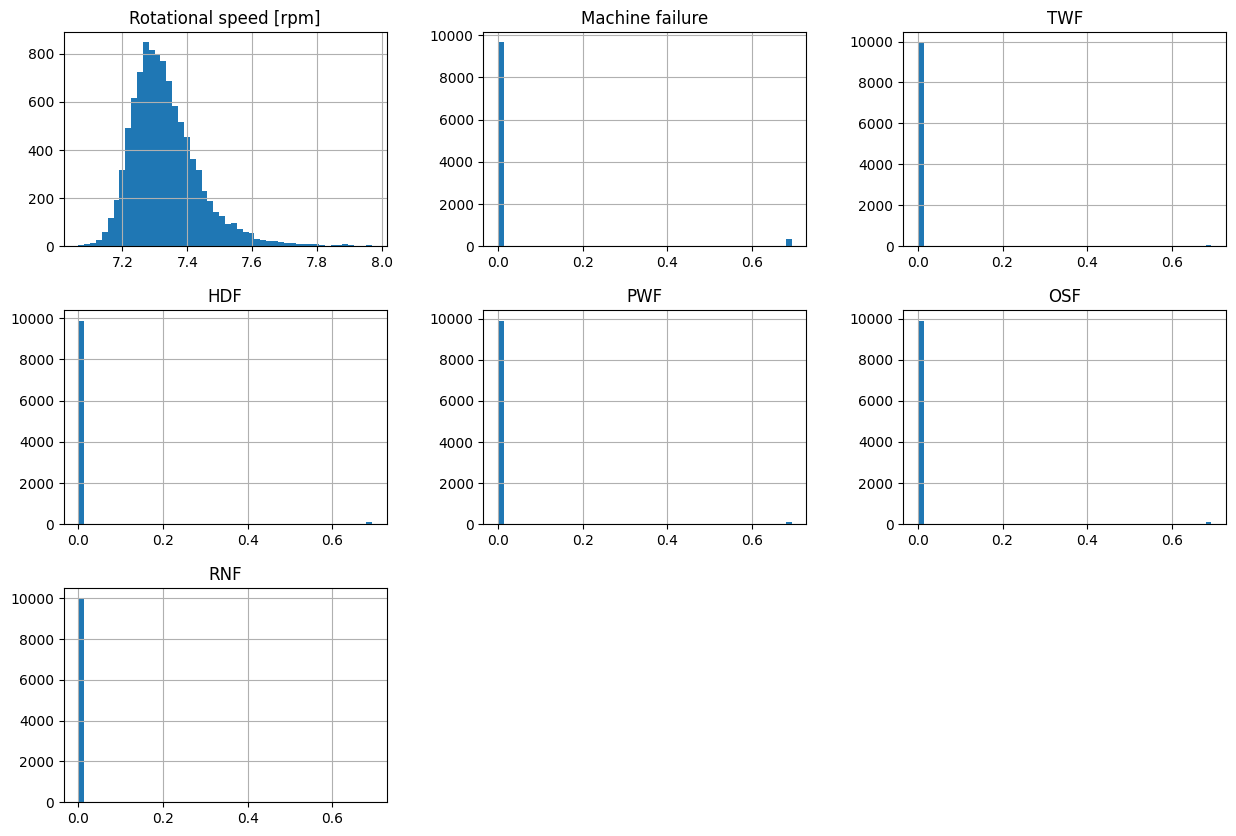

In [ ]:
numeric_columns = df_cleaned.select_dtypes(include=[np.number])

skewness = numeric_columns.skew()

skewed_columns = skewness[skewness > 1].index

# Applying log transformation to skewed columns
df_cleaned[skewed_columns] = np.log1p(df_cleaned[skewed_columns])

# Visualising the transformation effect
df_cleaned[skewed_columns].hist(bins=50, figsize=(15, 10))
plt.show()

## Removing outliers

As outliers can affect analysis, as they are values that do not follow the general trend of the data they can lead to inaccurate analysis by influencing the results. By using the Interquartile range (IQR) method it indentifies and removes values outside of the typical range. This is 1.5 times the IQR above the 75th percentile or below the 25th percentile.  This is used within this project to help with outliers.

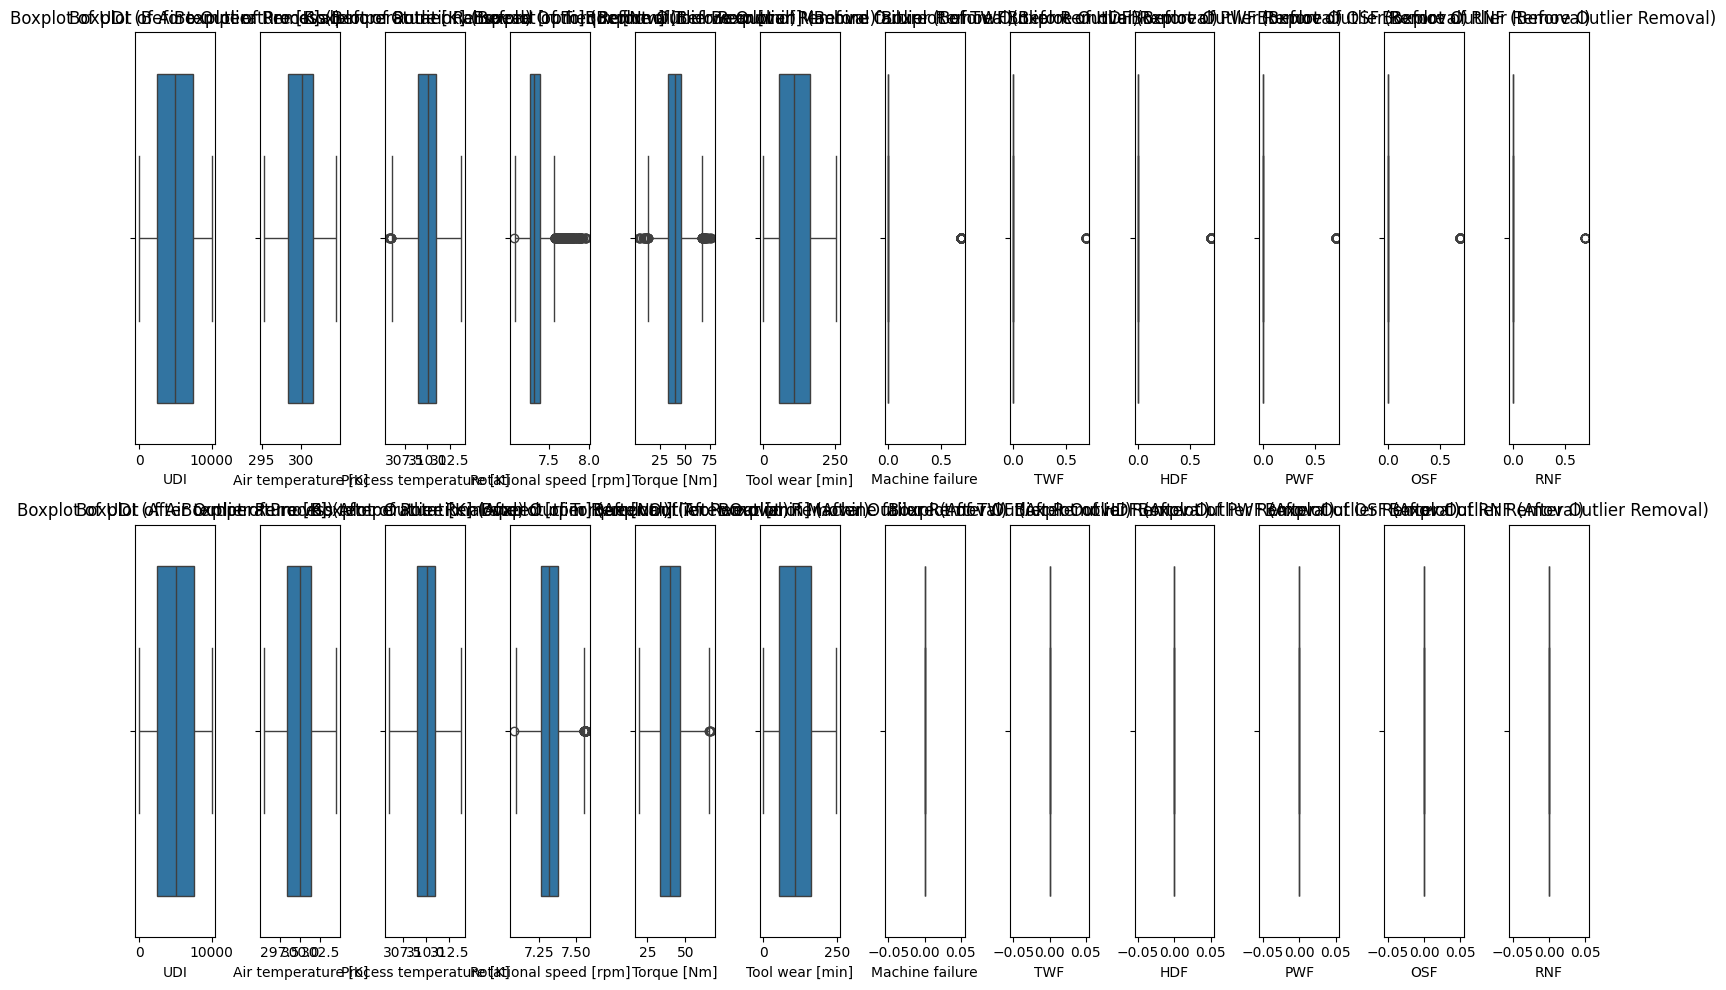

In [ ]:
numeric_columns = df_cleaned.select_dtypes(include=[np.number])

# Handling NaN and infinite values
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cleaned.dropna(inplace=True)

# Calculating Quantiles for IQR
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Defining the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying outliers (for each column in the numeric data)
outliers = ((numeric_columns < lower_bound) | (numeric_columns > upper_bound))

# Plotting original data distributions
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns.columns):
    plt.subplot(2, len(numeric_columns.columns), i + 1)
    sns.boxplot(x=numeric_columns[column])
    plt.title(f'Boxplot of {column} (Before Outlier Removal)')

# Removing the outliers
df_no_outliers = numeric_columns[~outliers.any(axis=1)]

# Plotting data distributions after outlier removal
for i, column in enumerate(numeric_columns.columns):
    plt.subplot(2, len(numeric_columns.columns), len(numeric_columns.columns) + i + 1)
    sns.boxplot(x=df_no_outliers[column])
    plt.title(f'Boxplot of {column} (After Outlier Removal)')

plt.tight_layout()
plt.show()

## Dropping overly correlated columns

As highly correlated features can cause redundancy in the data, removing one of the correlated columns reduces redundancy and makes the model more stable and interpretable. by computing the correlation matrix of the data and indentifying columns with a correlation higher than the threshold (0.9) the columns are then dropped to avoid highly correlated features. Here is example code used within this project

UDI                          int64
Product ID                 float64
Type                       float64
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]     float64
Torque [Nm]                float64
Tool wear [min]            float64
Machine failure            float64
TWF                        float64
HDF                        float64
PWF                        float64
OSF                        float64
RNF                        float64
dtype: object


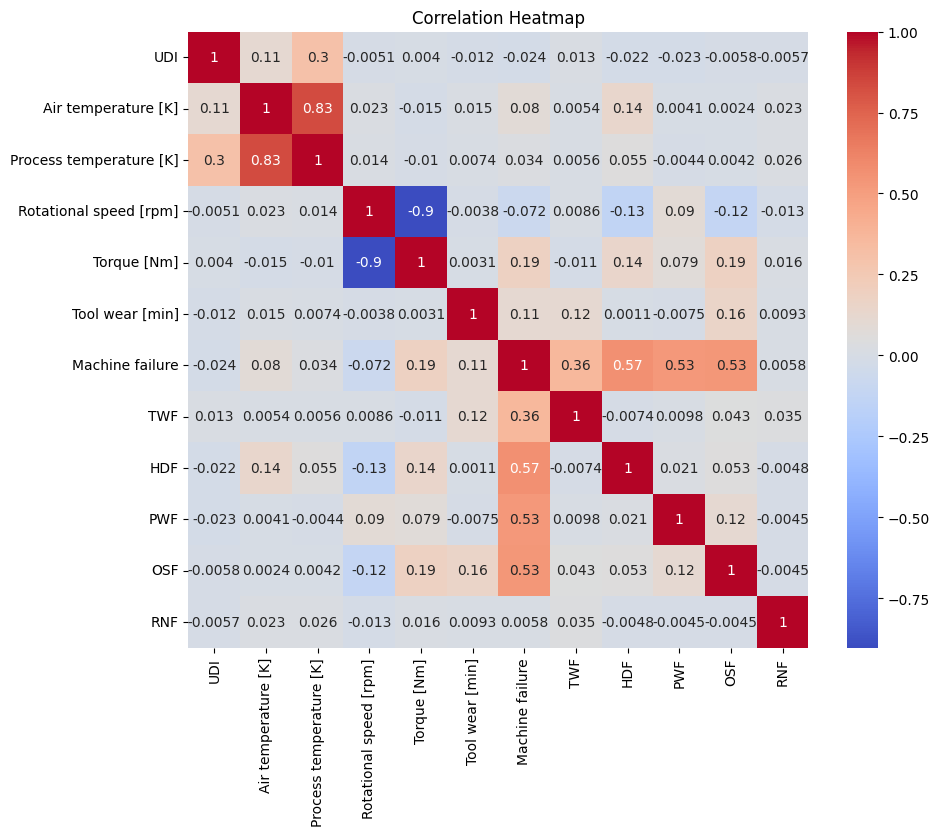

Remaining numeric columns after dropping highly correlated ones: Index(['UDI', 'Air temperature [K]', 'Rotational speed [rpm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')


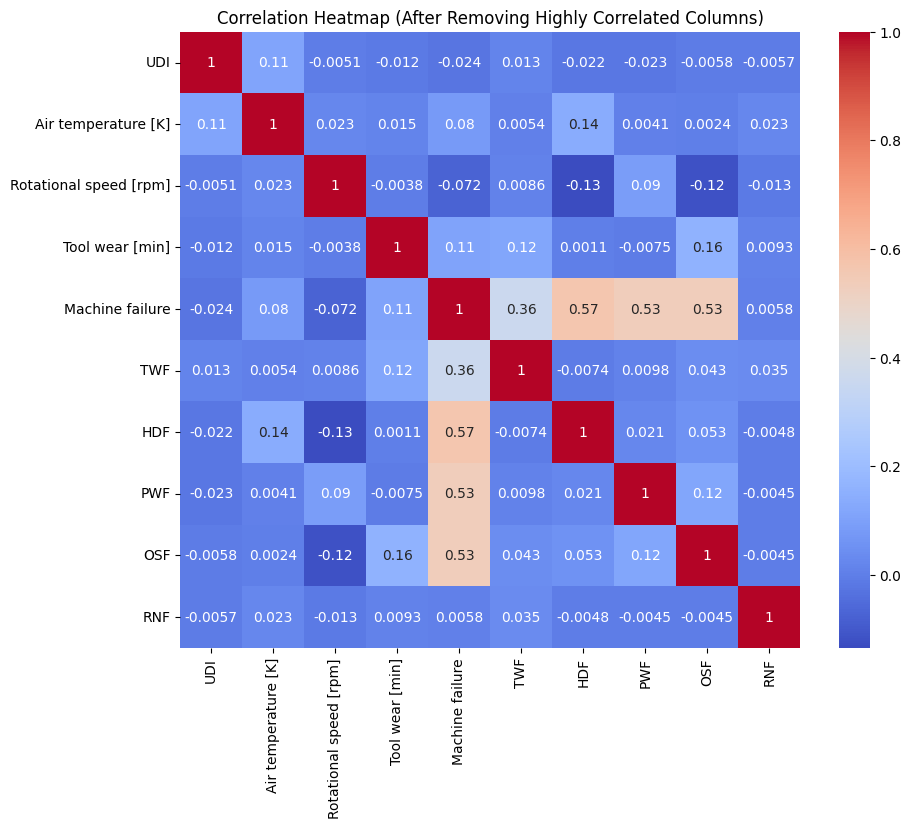

In [ ]:
non_numeric_columns = df_cleaned.select_dtypes(exclude=[np.number]).columns

# Dropping non-numeric columns

df_cleaned_numeric = df_cleaned.drop(columns=non_numeric_columns)

df_cleaned[non_numeric_columns] = df_cleaned[non_numeric_columns].apply(pd.to_numeric, errors='coerce')

df_cleaned.to_csv('df_cleaned.csv', index=False)

# Checking if any non-numeric columns remain
print(df_cleaned.dtypes)

# Compute the correlation matrix for numeric columns
correlation_matrix = df_cleaned_numeric.corr()

# Visualising the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Removing overly correlated columns (correlation > 0.7)
threshold = 0.7
columns_to_drop = set()

# Looping through the correlation matrix to identify columns to drop
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            columns_to_drop.add(colname)

# Dropping the columns with high correlation
df_no_corr = df_cleaned_numeric.drop(columns=columns_to_drop)

# Checking remaining numeric columns
print(f"Remaining numeric columns after dropping highly correlated ones: {df_no_corr.columns}")

# Visualising the cleaned correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_no_corr.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (After Removing Highly Correlated Columns)")
plt.show()



## Conclusion

In this notebook, we performed essential preprocessing steps to clean and transform the manufacturing process dataset. Each of the steps above helps ensure that the data is suitable for modelling and analysis, addressing the above issues. After these steps the data is cleaner, more consistent an ready for further analysis and visulisation